## "Opinion-Fact classification and Opinion sub-categorical classification in Phrase level in news article".

#### In the online world, people post texts or pictures in social media and comment in online news articles to express their views on some events or different topics of news articles. We can broadly classify a sentence or phrase (tweet, comment etc.) into opinion (statements based on a belief or view on a fact) or fact (which can be proved true or false).

In this project our objective is to 
1. Classify phrases into opinion-fact and opinion subcategories using deep learning method
2. Identify how suppression and domination occurs into sentence level or paragraph level
3. Application into Social Media : comments, news article sections (Sports, Politics etc.)
4. How it is related to / different from word or phrase level sentiment analysis.

Paricularly in this report we have tried to do the exploratory data analysis of the news articles and opinion-facts sentences. The report layout is as follows:

Section A: Exploratory Data Analysis

Section B: Network Analysis

Section C: Results of basic models implemented in R.

Section D: Implementation of deep learning models.


###  Modules and Global Settings

In [28]:
import tensorflow as tf            
import pandas as pd                 
import numpy as np       
import keras
import sklearn.model_selection     # For u|sing KFold
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing import text
from keras.layers import Bidirectional
import os                          # For filepath, directory handling
import sys                         # System-specific parameters and functions
import tqdm                        # Use smart progress meter
import seaborn as sns              # For pairplots
import matplotlib.pyplot as plt    # Python 2D plotting library
import matplotlib.cm as cm         # Color map
from IPython.display import Image
%matplotlib inline              

# Section A: Exploratory Data Analysis

### Disribution of various opinion and fact sentences
Total labelled articles were around 250

# Section B: Network Analysis
### In this we tried to analyse news articles by representing it into a network.

###### First we calculate similarity matrix for all the news articles and then kept a threshold to mark an edge between two similar articles. We implemented cosine similarity. Each news article was represented by a node and an edge represented if two articles are similar or not. For simplicity we considered undirected graph.
There were 535 news articles in total and we removed articles having degree centrality less than 3

#### Our hypothesis is to check if there is any pattern of opinions and facts phrases for different topics of the news articles and how sub-categories of opinion are distributed across different topics.
##### We could have implement topic modeling technique for all articles but without analysis it via a network we wouldn't have been able to decide on the number of topics.

#### Hence, we create network of the articles based on similarity matrix and then applied community detection algorithm (Louvain Algorithm) to check how many different topics are there in the articles.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, max_features=200000,
                                 min_df=0.02, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(doc_complete) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

# no need to normalize, since Vectorizer will return normalized tf-idf
pairwise_similarity = tfidf_matrix * tfidf_matrix.T


Wall time: 11.9 s
(535, 2152)


In [37]:
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.metrics import jaccard_similarity_score 

cosine = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine)


[[1.         0.03628734 0.03447197 ... 0.01889693 0.03790169 0.03238389]
 [0.03628734 1.         0.06567805 ... 0.02833068 0.05396236 0.08927397]
 [0.03447197 0.06567805 1.         ... 0.05962924 0.05610252 0.08348517]
 ...
 [0.01889693 0.02833068 0.05962924 ... 1.         0.40350823 0.04791627]
 [0.03790169 0.05396236 0.05610252 ... 0.40350823 1.         0.07626145]
 [0.03238389 0.08927397 0.08348517 ... 0.04791627 0.07626145 1.        ]]


In [7]:
max=-1
min=2
i1=0
j1=0
adj_matrix=[[0 for x in range(535)] for y in range(535)] 
for j in range(535):
    for i in range(535):
        if(i!=j and cosine[i][j]<min):
            min=cosine[i][j]
        if(i!=j and cosine[i][j]>max):    
            max=cosine[i][j]
            i1=i
            j1=j
        if(i!=j and cosine[i][j]>=0.2):
            adj_matrix[i][j]=1
print(max,i1,j1)


0.9965532076546446 332 197


In [8]:
import networkx as nx
adj_matrix_np=pd.DataFrame(adj_matrix)
#adj_matrix_np=adj_matrix_np[~np.all(adj_matrix_np == 0, axis=1)]
#adj_matrix_np=adj_matrix_np.loc[:, (adj_matrix_np != 0).any(axis=0)]
adj_matrix_np.drop([col for col, val in adj_matrix_np.sum().iteritems() if val < 5], axis=1,inplace=True)
adj_matrix_np=adj_matrix_np.iloc[list(adj_matrix_np.columns)]
print(adj_matrix_np.shape)
G=nx.from_numpy_matrix(np.array(adj_matrix_np))


(442, 442)


Name: 
Type: Graph
Number of nodes: 442
Number of edges: 7239
Average degree:  32.7557


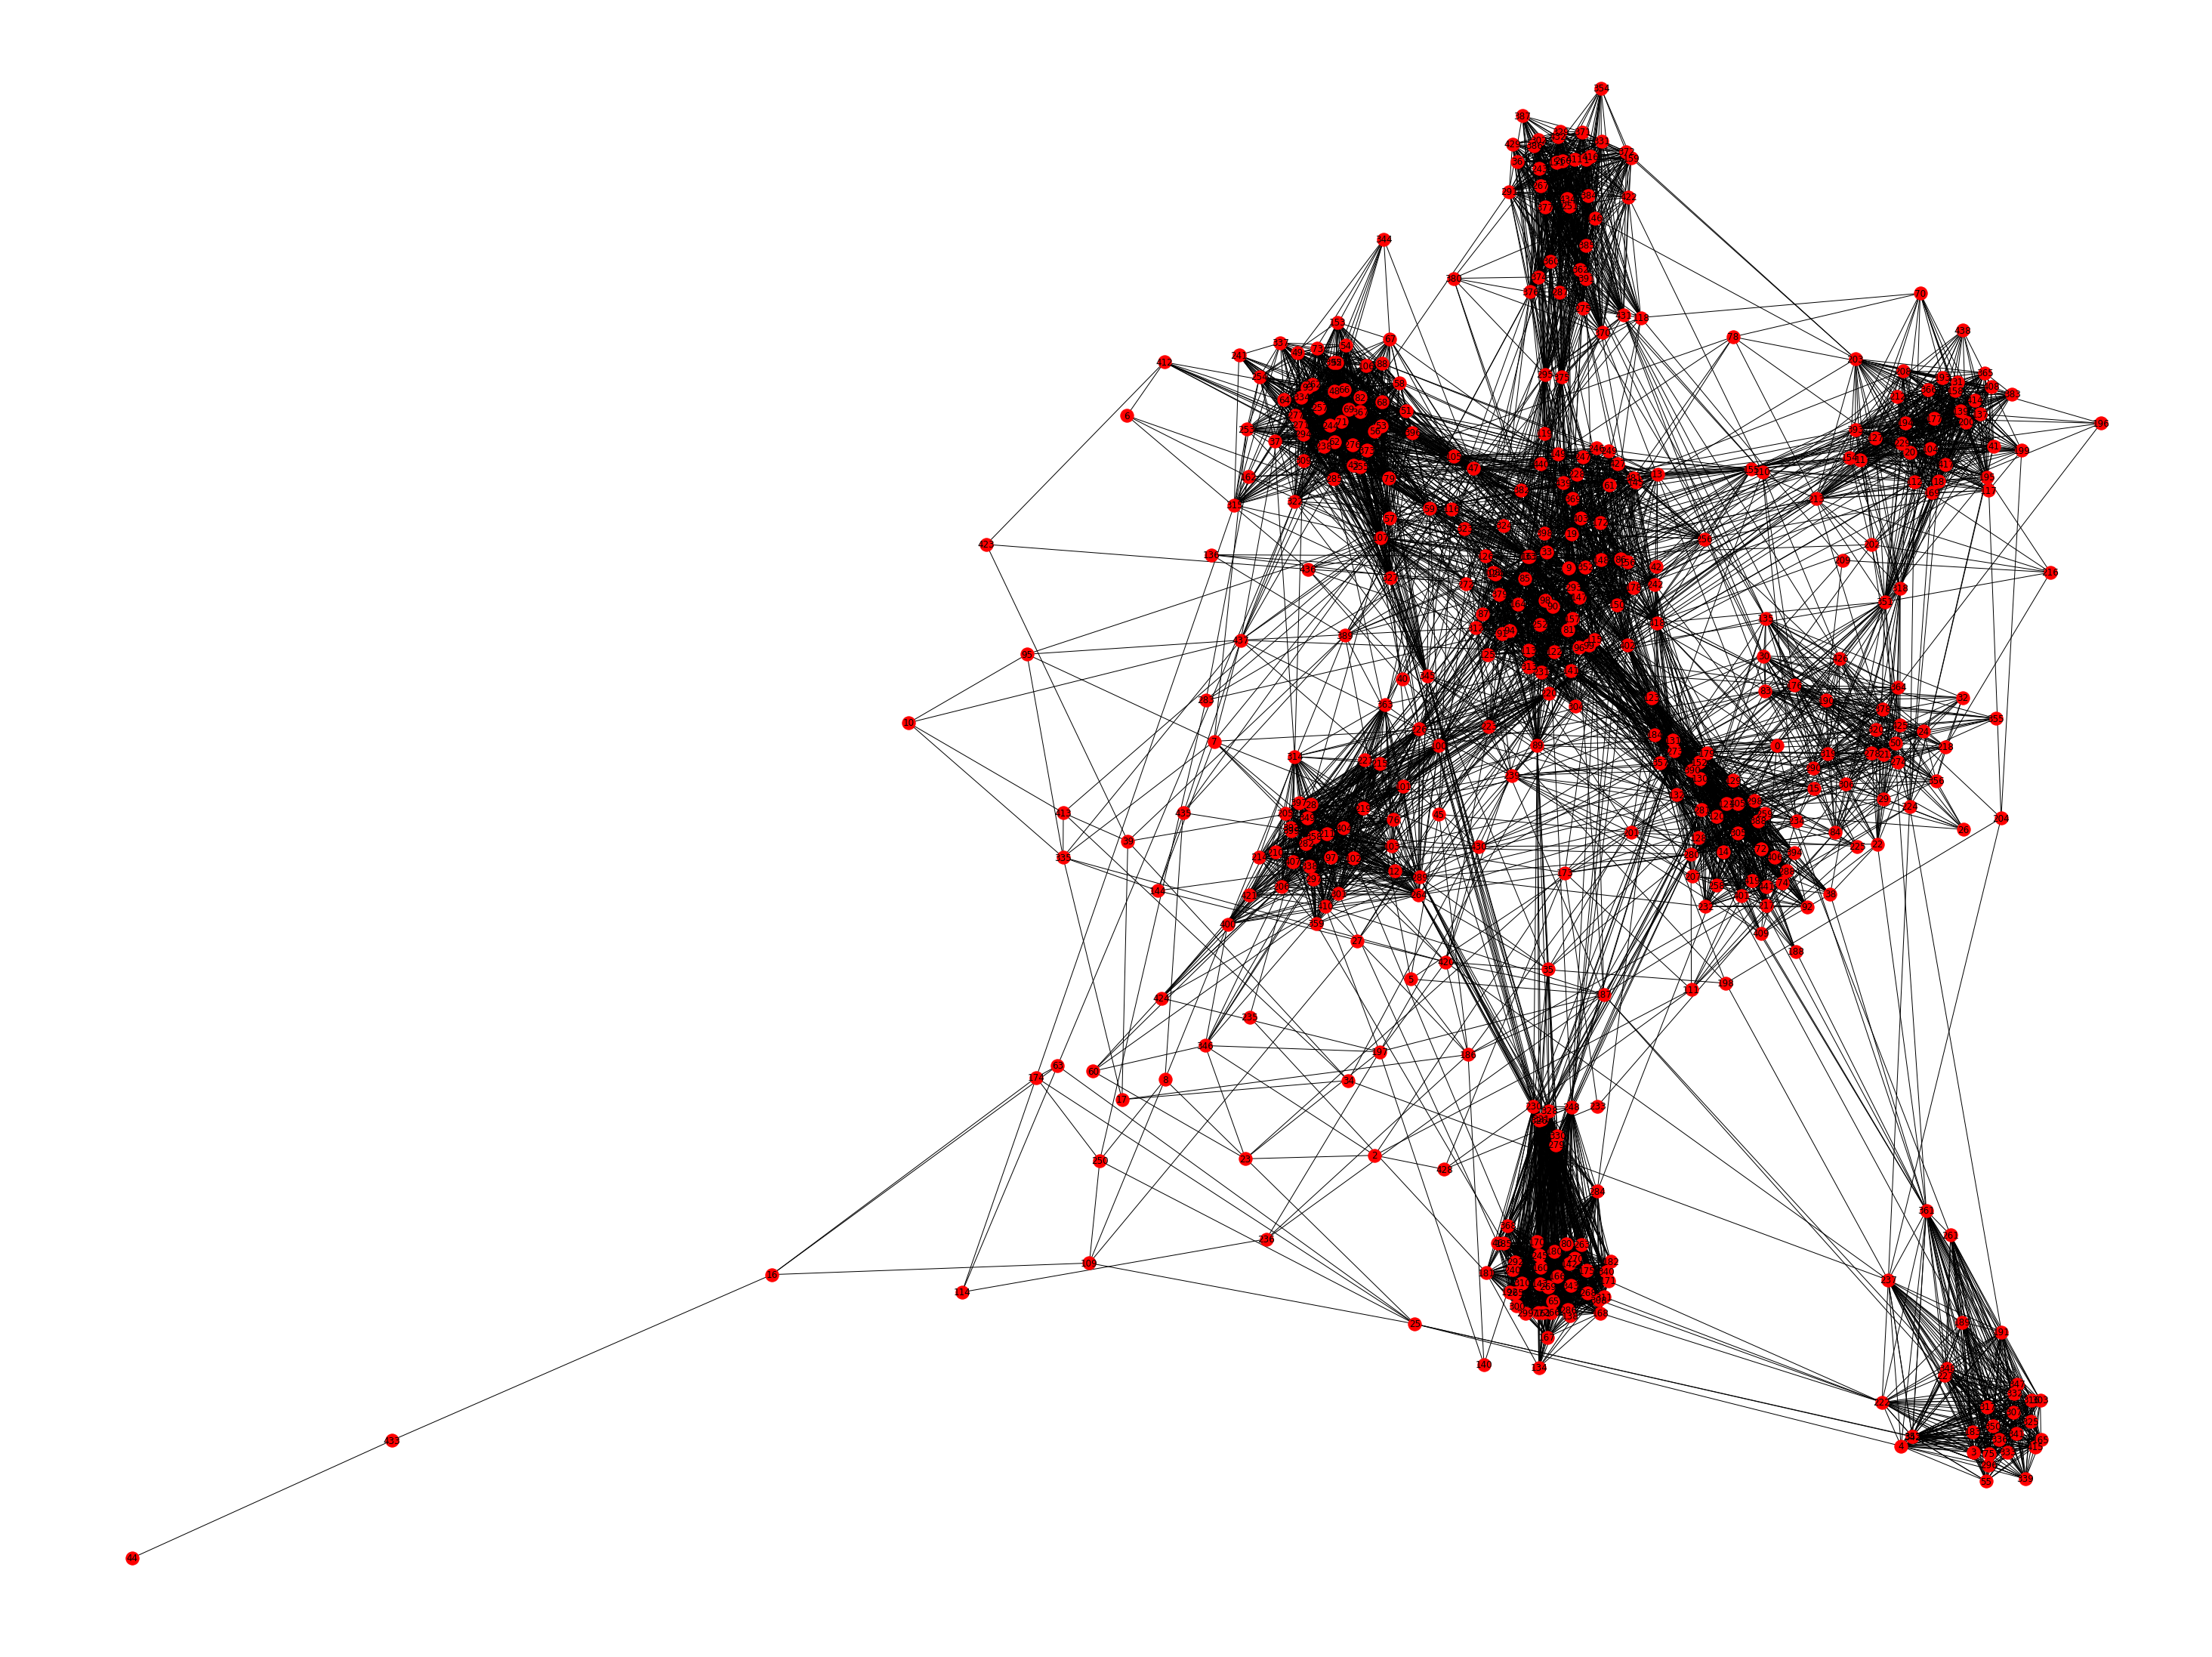

In [9]:
#Quick snapshot of the Network
print(nx.info(G))
plt.figure(figsize=(40,30)) 
nx.draw(G,with_labels=True)


# Community Detection

Louvain Modularity:  0.7535561574662699


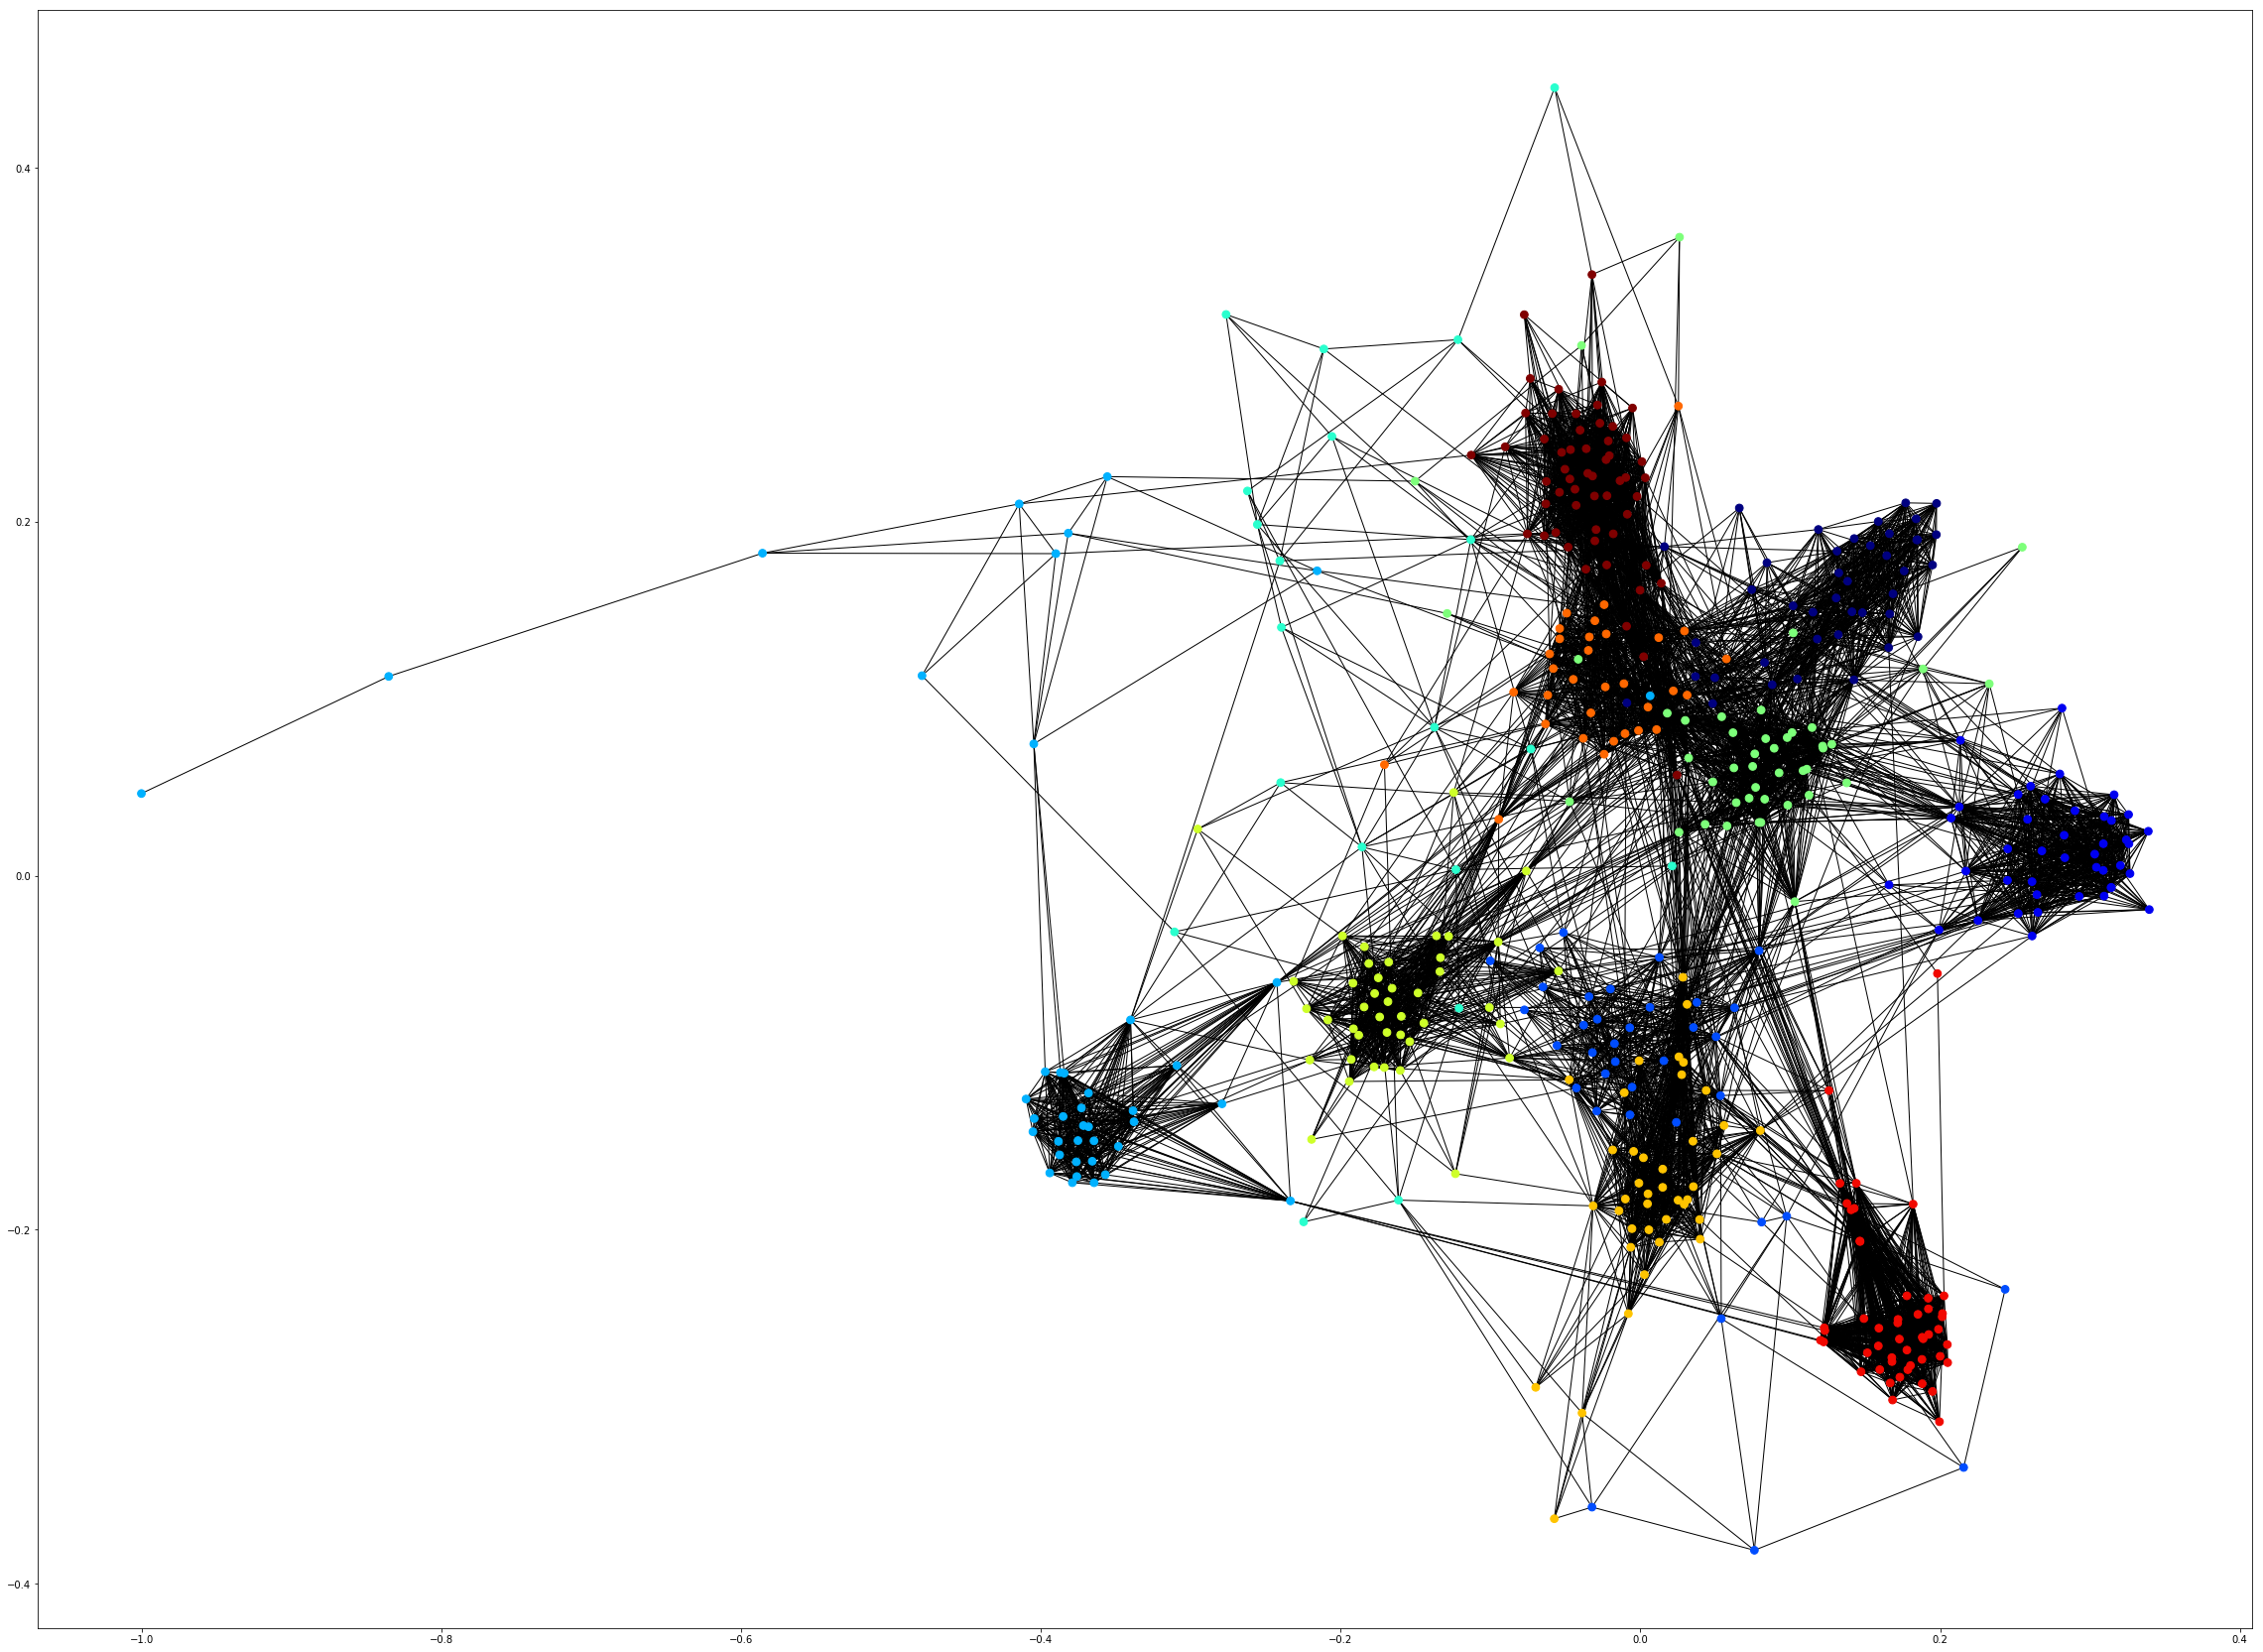

In [24]:
import louvain
import community.community_louvain as community

part = community.best_partition(G)
print ("Louvain Modularity: ", community.modularity(part, G))
values = [part.get(node) for node in G.nodes()]

plt.figure(figsize=(40,30))

#Create network layout for visualizations
spring_pos = nx.spring_layout(G)
nx.draw_networkx(G,  cmap = plt.get_cmap("jet"), node_color = values, node_size = 60, with_labels = False)


# Beetweeness Centrality

In [ ]:
from multiprocessing import Pool
import itertools

def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition
def btwn_pool(G_tuple):
    return nx.betweenness_centrality_source(*G_tuple)

def between_parallel(G, processes = None):
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)
 
    bet_map = p.map(btwn_pool,
                        zip([G]*num_partitions,
                        [True]*num_partitions,
                        [None]*num_partitions,
                        node_partitions))
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c


In [ ]:
bt = between_parallel(G)
top = 10

max_nodes =  sorted(bt.iteritems(), key = lambda v: -v[1])[:top]
bt_values = [5]*len(G_fb.nodes())
bt_colors = [0]*len(G_fb.nodes())

for max_key, max_val in max_nodes:
    bt_values[max_key] = 150
    bt_colors[max_key] = 2
 
nx.draw_networkx(G, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)

# Topic Modeling

In [38]:
from nltk.corpus import stopwords 
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    #tokens_pos = ''.join(token for token, pos in pos_tag(doc) if (pos.startswith('N') | pos.startswith('J') | pos.startswith('V'))) 
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized
def noun_verb(doc):
    tokens_pos = [token for token, pos in pos_tag(doc) if (pos.startswith('N') | pos.startswith('J'))]
    return tokens_pos

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\punee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\punee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\punee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\punee\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [39]:
import os
import glob
 
path = 'E:\PGDBA\KGP\CN\Project\Data\Raw Files/'
raw_data=[]
for infile in glob.glob( os.path.join(path, '*.csv') ):
    x=pd.read_csv(infile)
    temp=""
    for sentence in x.iloc[:,0]:
        temp+=sentence
    raw_data.append(temp)
doc_complete=raw_data
doc_clean = [clean(doc).split() for doc in doc_complete] 
doc_clean[0]
doc_clean = [noun_verb(doc) for doc in doc_clean]


In [40]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]


C:\Users\punee\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [41]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50)


In [42]:
print(ldamodel.print_topics(num_topics=10, num_words=5))


[(0, '0.018*"mr" + 0.017*"chavez" + 0.013*"government" + 0.009*"president" + 0.007*"military"'), (1, '0.007*"mongolian" + 0.007*"visit" + 0.007*"mongolia" + 0.005*"dostum" + 0.005*"official"'), (2, '0.051*"space" + 0.023*"russian" + 0.021*"station" + 0.010*"russia" + 0.009*"launch"'), (3, '0.026*"u" + 0.023*"state" + 0.016*"united" + 0.016*"bush" + 0.016*"country"'), (4, '0.023*"prisoner" + 0.021*"u" + 0.012*"war" + 0.010*"detainee" + 0.009*"base"'), (5, '0.006*"u" + 0.005*"leader" + 0.005*"day" + 0.004*"jordan" + 0.003*"government"'), (6, '0.012*"country" + 0.012*"year" + 0.010*"emission" + 0.009*"kyoto" + 0.009*"climate"'), (7, '0.021*"election" + 0.018*"president" + 0.014*"mugabe" + 0.014*"zimbabwe" + 0.013*"country"'), (8, '0.006*"boat" + 0.006*"minister" + 0.006*"ship" + 0.005*"illegal" + 0.005*"attack"'), (9, '0.038*"palestinian" + 0.027*"israeli" + 0.025*"israel" + 0.010*"settlement" + 0.009*"peace"')]


# Section C: Basic NLP based models' results
The models were implemented in R and hence code is not available in this report

In [ ]:
PATH = "C:/Users/abhishkek/Desktop/"


# Section D: Implementation of Deep Learning Models
###### We specifically implemented LSTM and Bi-direction LSTM models and measured the performance using accuracy metric.
###### Futher, in deep learning models we observed that the dataset was relatively small and there was class imbalance as well. Due to this the model could not genralize well and although the training accuracy was around 84% but the test accuracy dropped to 71%. We might need to check the data again and implement data augmentation techniques to balance the classes.

### Read Input Data

In [95]:
raw_data = pd.read_csv('E:\PGDBA\KGP\CN\Project\LSTM_Model\Raw_Data.csv')
X=raw_data.iloc[:,0]
y=raw_data.iloc[:,1]
y_f = pd.factorize(y)
y=y_f[0]
X.describe()

count                                                  4618
unique                                                 4618
top       Meanwhile Foreign Affairs spokesman Ronnie Mam...
freq                                                      1
Name: Sentence, dtype: object

### Train and Test Split

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.25)
X_train.shape
X_test.shape
y_train.shape
y_test.shape

(1155,)

### Preprocess the Data

In [97]:
# truncate and pad input sequences
temp=""
for x in X_train:
    temp+=" "+x
print(len(set(temp.split())))

tk = text.Tokenizer(num_words=7000,lower=False, split=" ")
tk.fit_on_texts(X_train)
X_train_sq= tk.texts_to_sequences(X_train)
X_test_sq= tk.texts_to_sequences(X_test)

max_review_length = 50
X_train_sq = sequence.pad_sequences(X_train_sq, maxlen=max_review_length)
X_test_sq = sequence.pad_sequences(X_test_sq, maxlen=max_review_length)


y_train = keras.utils.to_categorical(y_train, num_classes=5)
y_test = keras.utils.to_categorical(y_test, num_classes=5)

10883


### Create LSTM Model

In [121]:
# create the model
embedding_vecor_length = 64
model = Sequential()
model.add(Embedding(500, 64, input_length=500))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
# Convert labels to categorical one-hot encoding
model.fit(X_train_sq, y_train, epochs=5, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 500, 64)           128000    
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 500, 64)           12352     
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 250, 64)           0         
_________________________________________________________________
lstm_87 (LSTM)               (None, 250, 256)          328704    
_________________________________________________________________
lstm_88 (LSTM)               (None, 250, 128)          197120    
_________________________________________________________________
lstm_89 (LSTM)               (None, 250, 128)          131584    
_________________________________________________________________
lstm_90 (LSTM)               (None, 64)                49408     
__________

In [129]:
# Final evaluation of the model
scores = model.evaluate(X_test_sq, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 71.00%


### Create Bi-directional LSTM model

In [98]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)


In [99]:
# create the model
embedding_vecor_length = 64
model = Sequential()
model.add(Embedding(7000, 64, input_length=50))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(256,return_sequences=True)))
model.add(Bidirectional(LSTM(256,return_sequences=True,dropout=0.5)))
model.add(Bidirectional(LSTM(128,dropout=0.5)))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train_sq, y_train, epochs=3, batch_size=64,class_weight=class_weight)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 50, 64)            448000    
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 50, 512)           657408    
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 50, 512)           1574912   
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 256)               656384    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 645       
Total params: 3,370,245
Trainable params: 3,370,245
Non-trainable params: 0
_________________________________________________________________


In [100]:
# Final evaluation of the model
scores = model.evaluate(X_test_sq, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 65.80%


In [101]:
yhat = model.predict_classes(X_test_sq, verbose=0)

In [102]:
yhat_df=pd.DataFrame(yhat)
X_train_df=pd.DataFrame(X_train)
final = yhat_df.append(X_train_df)
